In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import rubin_sim.maf as maf

In [2]:
opsdb = 'too_elab_heavy_r128_d2_griz_v3.4_10yrs.db'
run_name = opsdb.replace('.db.', '')

conn = sqlite3.connect(opsdb)

In [3]:
# First guess .. New stacker to make simpler note name to group ToOs by event

# Rerun cell if needed
try:
    del maf.BaseStacker.registry['__main__.ToOEventStacker']
except KeyError:
    pass


class ToOEventStacker(maf.BaseStacker):
    """Add a tag to each visit that corresponds to a too trigger,
    identifying the visit as belonging to that trigger event.

    The action of the stacker is to add a new column to the 
    observation data, `too_trigger`, which splits the expected 
    `note` information of something like "ToO, 0_t1" into "ToO 0" 
    (where "0" corresponds to the particular trigger and in the original
    note, "t1" was the first round of ToO observations, etc.).

    Parameters
    ----------
    note_col : `str`, optional
        The name of the column containing the "note" information.
    """

    cols_added = ['too_trigger']

    def __init__(self, note_col="note"):
        self.note_col = note_col
        self.cols_req = [self.note_col]
        self.cols_added_dtypes = [int]
        self.units = ['']

    @staticmethod
    def map_too_note(x):
        if x['note'].startswith('ToO'):
            trigger_id = x['note'].split('_')[0].split(',')[-1].strip(' ')
            trigger_id = int(trigger_id)
        else:
            trigger_id = -999
        return trigger_id
            
    def _run(self, sim_data, cols_present=False):
        if cols_present:
            # Column already present in data; assume it is correct and does not need recalculating.
            return sim_data
        df = pd.DataFrame(sim_data)
        too_trigger = df.apply(self.map_too_note, axis=1)
        print(len(df), len(sim_data), len(too_trigger.values))
        sim_data['too_trigger'] = too_trigger.values
        return sim_data

In [4]:
def generate_too_slicer(events, n_files=1, d_min=50, d_max=50,seed=42):
    """Generate a slicer that includes the ToO trigger event information. 

    Parameters
    ----------
    events : `np.Ndarray`, `(N,)`
       Numpy recarray containing the too trigger information 
       (typically from the opsdb.events table).
    seed : `float`
        The seed passed to np.random.default_rng.
    n_files : `int`
        The number of different kilonova lightcurves to use.
    d_min : `float` or `int`
        Minimum luminosity distance (Mpc).
    d_max : `float` or `int`
        Maximum luminosity distance (Mpc).
    """
    rng = np.random.default_rng(seed=seed)
    n_events = len(events)
    # Let's just assign the peak time to the time of the trigger
    peak_times = events['mjd_start']
    # We can still have random types of KNes
    file_indx = np.floor(rng.uniform(low=0, high=n_files, size=n_events)).astype(int)
    # and random distances
    def rndm(a, b, g, size=1):
        """Power-law gen for pdf(x) proportional to x^{g-1} for a<=x<=b"""
        r = rng.random(size=size)
        ag, bg = a**g, b**g
        return (ag + (bg - ag) * r) ** (1.0 / g)
    distance = rndm(d_min, d_max, 4, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = maf.slicers.UserPointsSlicer(np.degrees(events['ra']), np.degrees(events['dec']), lat_lon_deg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slice_points["too_trigger"] = events['too_event']
    slicer.slice_points["peak_time"] = peak_times
    slicer.slice_points["file_indx"] = file_indx
    slicer.slice_points["distance"] = distance
    return slicer

In [5]:
events = pd.read_sql('select * from events', conn)
events.rename({'index':'too_event'}, axis=1, inplace=True)
events['radius'] = np.radians(100)
events = events.to_records()
print(len(events))
events['too_event']

1280


array([   0,    1,    2, ..., 1277, 1278, 1279])

In [46]:

# Make a one-d slicer based on too_trigger to check for observations acquired for a given ToO

# extend the bins just to make sure we don't drop the last event
bins = np.concatenate([events['too_event'], np.array([len(events)])])
too_simple_slicer = maf.OneDSlicer(slice_col_name='too_trigger', bins=bins)
too_constraint = 'note like "%ToO%"'

# can chain a spatial slicer off of this to make maps of healpix subsets .. 

# but for now just count nvisits per ToO
count_too = maf.MetricBundle(maf.CountMetric('too_trigger', metric_name="ToONvisit_Histogram"),
                                 too_simple_slicer,
                                 too_constraint,
                                 stacker_list=[ToOEventStacker()],
                                 run_name=run_name)
# While this would work once the MAF stacker above was properly added to maf, it looks like the ColInfo object
# doesn't remember about this stacker when run here ... (odd). 
# So the too_trigger column "looks" like it should come from the database, but obviously it doesn't.
# so hack it ..
count_too.db_cols = ['note']

# count overall time from first to last cycle? (should correlate with number..)
time_too = maf.MetricBundle(maf.FullRangeMetric('observationStartMJD'),
                            too_simple_slicer, too_constraint, run_name=run_name)
time_too.db_cols = ['note']

# and also make too map on-sky
too_slicer = generate_too_slicer(events)

# map of total number of visits per too
map_too = maf.MetricBundle(maf.CountMetric('observationStartMJD'), 
                           too_slicer, too_constraint, run_name=run_name)

# count number of filters per too
nfilters_too = maf.MetricBundle(maf.CountUniqueMetric('filter'),
                                too_slicer, too_constraint, run_name=run_name)

map_time_too = maf.MetricBundle(maf.FullRangeMetric('observationStartMJD'),
                                too_slicer, too_constraint, run_name=run_name)

map_tmin_too = maf.MetricBundle(maf.MinMetric('observationStartMJD'),
                                too_slicer, too_constraint, run_name=run_name)

# coadd depths .. although ideally would be coadd per cycle
depth_too = {}
for f in 'ugrizy':
    sql = f' and filter="{f}"'
    depth_too[f] = maf.MetricBundle(maf.Coaddm5Metric(),
                                    too_slicer,
                                    too_constraint + sql,
                                    run_name=run_name)
                             
g = maf.MetricBundleGroup([count_too, time_too, map_too, map_time_too, map_tmin_too, nfilters_too] + list(depth_too.values()), opsdb, verbose=True)
g.run_all()

Querying table None with constraint note like "%ToO%" and filter="g" for columns ['fieldDec', 'fieldRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 49878 visits
Running:  ['too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_CoaddM5_note_like_ToO_and_g_USER']
Processing slices: 100%|█████████████████| 1280/1280 [00:00<00:00, 8447.78it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note like "%ToO%" and filter="r" for columns ['fieldDec', 'fieldRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 19767 visits
Running:  ['too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_CoaddM5_note_like_ToO_and_r_USER']
Processing slices: 100%|█████████████████| 1280/1280 [00:00<00:00, 8990.78it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note like "%ToO%" and filter="z" for columns ['fieldDec', 'fieldRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 20860 visits
Running:  ['t

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:306: UserWarning: No data matching constraint note like "%ToO%" and filter="y"
  warnings.warn("No data matching constraint %s" % constraint)
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:312: UserWarning:  This means skipping metrics ['CoaddM5 : note like %ToO% and y : UserPointsSlicer']
  warnings.warn(" This means skipping metrics %s" % metrics_skipped)


Querying table None with constraint note like "%ToO%" and filter="i" for columns ['fieldDec', 'fieldRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 28566 visits
Running:  ['too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_CoaddM5_note_like_ToO_and_i_USER']
Processing slices: 100%|█████████████████| 1280/1280 [00:00<00:00, 9385.89it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note like "%ToO%" for columns ['fieldRA', 'observationStartMJD', 'rotSkyPos', 'note', 'fieldDec', 'filter']
Found 119071 visits
Running:  ['too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_ToONvisit_Histogram_note_like_ToO_ONED', 'too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_FullRange_observationStartMJD_note_like_ToO_ONED']
119071 119071 119071
Processing slices: 100%|████████████████| 1280/1280 [00:00<00:00, 46588.01it/s]
Completed metric generation.
Running:  ['too_elab_heavy_r128_d2_griz_v3_4_10yrs_db_Count_observationStartMJD_note_like_ToO_USER', 

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:306: UserWarning: No data matching constraint note like "%ToO%" and filter="u"
  warnings.warn("No data matching constraint %s" % constraint)
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:312: UserWarning:  This means skipping metrics ['CoaddM5 : note like %ToO% and u : UserPointsSlicer']
  warnings.warn(" This means skipping metrics %s" % metrics_skipped)


{'SkyMap': 1, 'Histogram': 2}

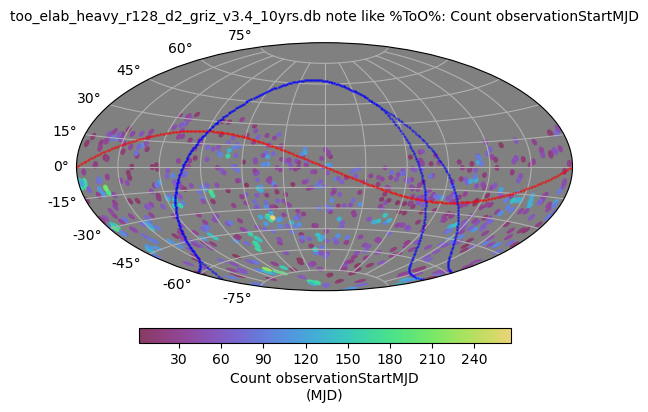

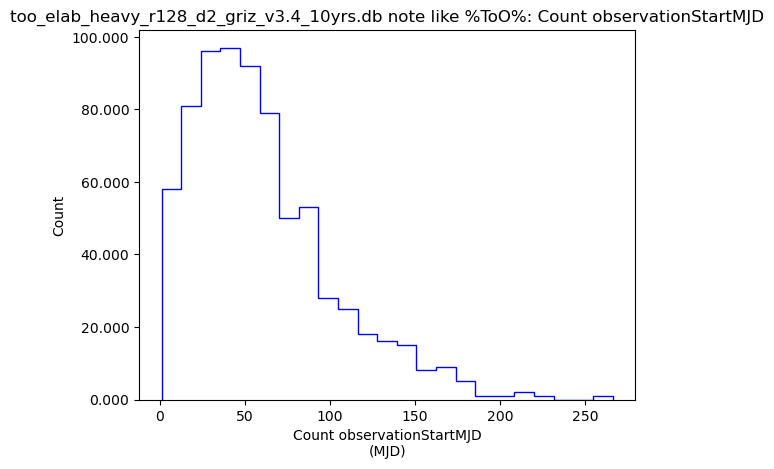

In [7]:
map_too.plot()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

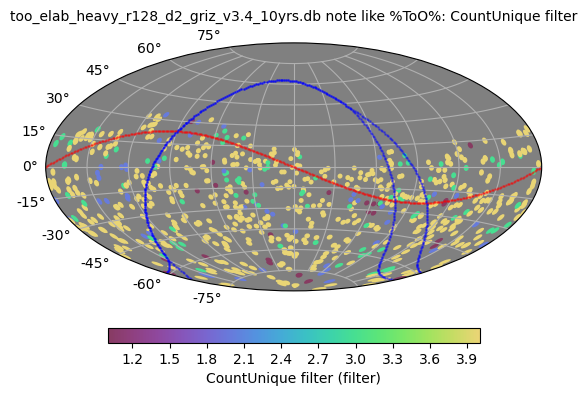

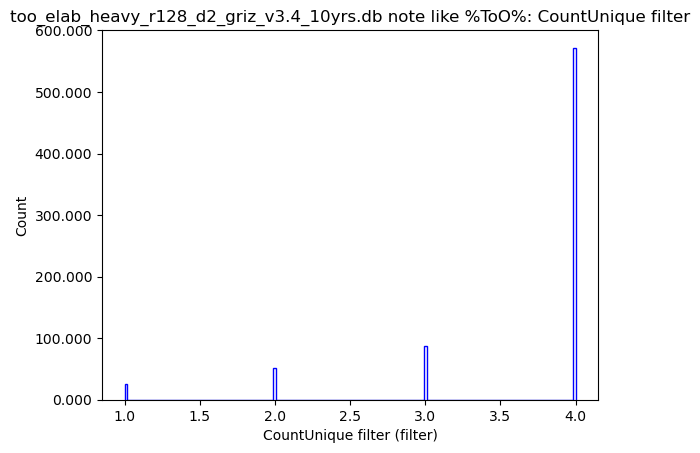

In [8]:
nfilters_too.plot()

{'SkyMap': 1, 'Histogram': 2}

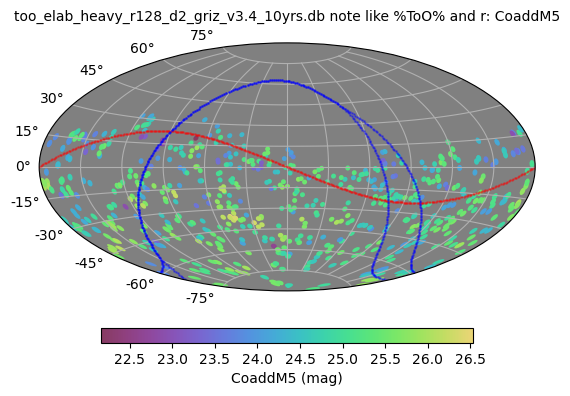

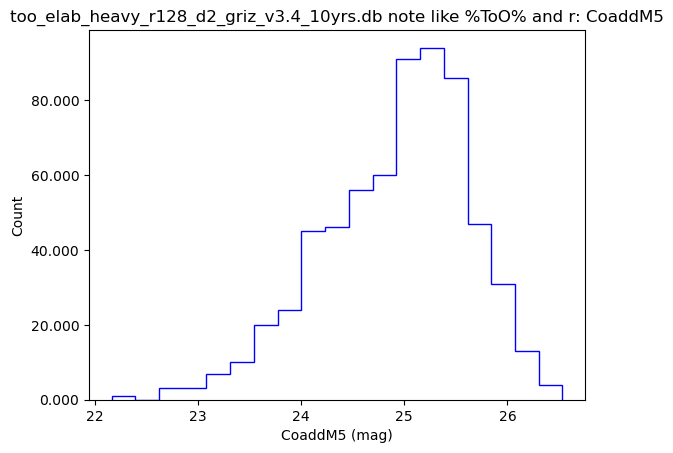

In [9]:
depth_too['r'].plot()

Text(0, 0.5, 'Number of visits')

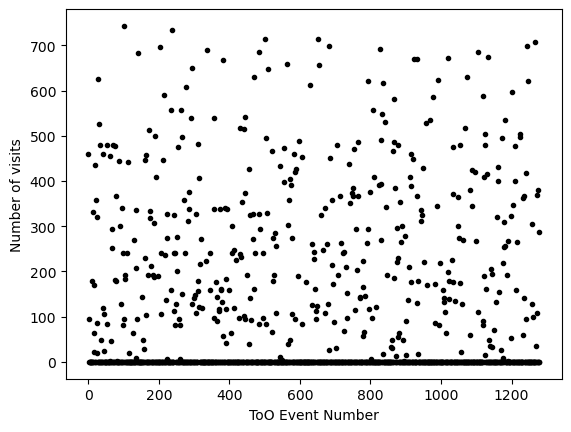

In [10]:
plt.plot(events['too_event'], count_too.metric_values.filled(0), 'k.')
plt.xlabel("ToO Event Number")
plt.ylabel("Number of visits")

Text(0, 0.5, 'Time Span of Visits for ToO')

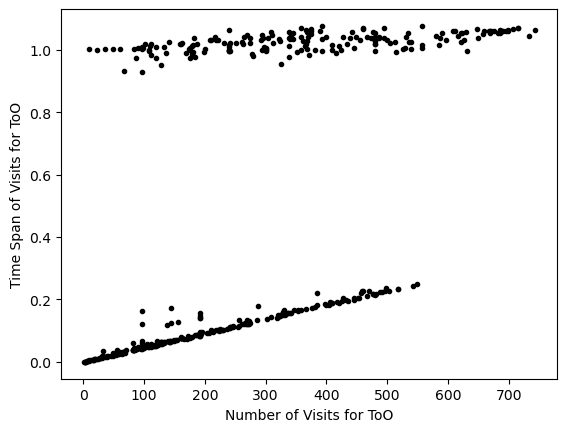

In [11]:
plt.plot(count_too.metric_values.compressed(), time_too.metric_values.compressed(), 'k.')
plt.xlabel("Number of Visits for ToO")
plt.ylabel("Time Span of Visits for ToO")

Text(0, 0.5, 'Time Span of Visits for ToO (center)')

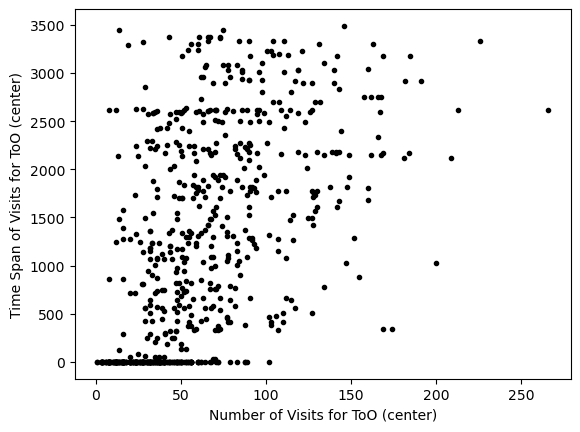

In [12]:
plt.plot(map_too.metric_values.compressed(), map_time_too.metric_values.compressed(), 'k.')
plt.xlabel("Number of Visits for ToO (center)")
plt.ylabel("Time Span of Visits for ToO (center)")

In [13]:
# Kilonova parameters for GW170817-like lightcurve
inj_params_list = [
    {"mej_dyn": 0.005, "mej_wind": 0.050, "phi": 30, "theta": 25.8},
]
filename = maf.get_kne_filename(inj_params_list)
filename

Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 25.8}
Found matches for 1/1           sets of parameters


['/Users/lynnej/rubin_sim_data/maf/bns/nsns_nph1.0e+06_mejdyn0.005_mejwind0.050_phi30_25.8.dat']

In [14]:
# Note mjd0 value=0 here .. this is important because t_start/t_end in *slicer* is used to set 'tpeak' in days.
# To sync those *days* and the *actual day*, mjd0 does a translation. 
# tpeak is just be set as an actual mjd to avoid this.

presto_metric = maf.PrestoColorKNePopMetric(
        metric_name="KNePopMetric_ToO",
        mjd_col="observationStartMJD",
        m5_col="fiveSigmaDepth",
        filter_col="filter",
        night_col="night",
        pts_needed=2,
        file_list=filename,
        mjd0=0,
        output_lc=False,
        skyregion="extragalactic",
        thr=0.003)


presto = maf.MetricBundle(presto_metric, too_slicer, too_constraint, run_name=run_name)

In [15]:
g2 = maf.MetricBundleGroup({"too": presto}, opsdb)
g2.run_all()

In [16]:
# If you accidentally overwrite one of score_s or score_p ... sigh ..
g2.bundle_dict = {'too': presto}
g2.reduce_all() 

In [17]:
g2.bundle_dict

{'too': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x19f6bde90>,
 'KNePopMetric_ToO_presto_color_detect': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x19dd35150>,
 'KNePopMetric_ToO_score_p': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x19dbbc9d0>,
 'KNePopMetric_ToO_score_s': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x19dbd5e10>}

In [18]:
# So which one was which again? 
# score_s looks like the metric which is 0 or 1, depending on whether the probability hits the threshold
score_s = g2.bundle_dict['KNePopMetric_ToO_score_s']

201.0 too triggers hit the required threshold


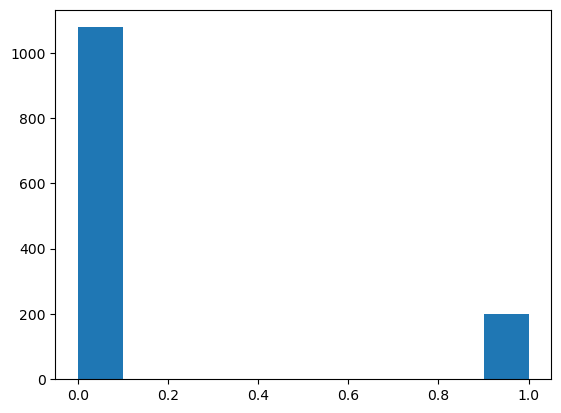

In [19]:
print(f"{score_s.metric_values.sum()} too triggers hit the required threshold")
_ = plt.hist(score_s.metric_values, bins=10)

(array([1.002e+03, 1.200e+01, 0.000e+00, 1.000e+00, 1.200e+01, 4.000e+00,
        0.000e+00, 1.400e+01, 0.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 1.400e+01, 1.000e+00, 7.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.010e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

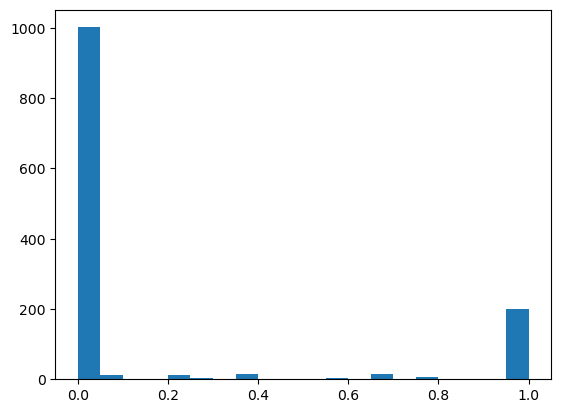

In [20]:
# So score_p is the probability of being able to distinguish a KNe from the background in each trigger
score_p = copy.deepcopy(g2.bundle_dict['KNePopMetric_ToO_score_p'])
plt.hist(score_p.metric_values, bins=20)

{'SkyMap': 1, 'Histogram': 2}

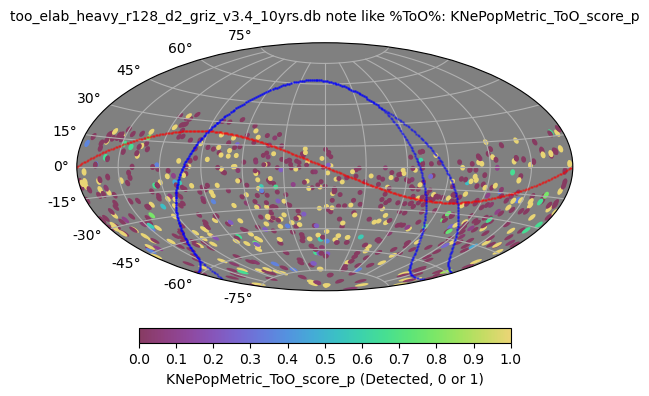

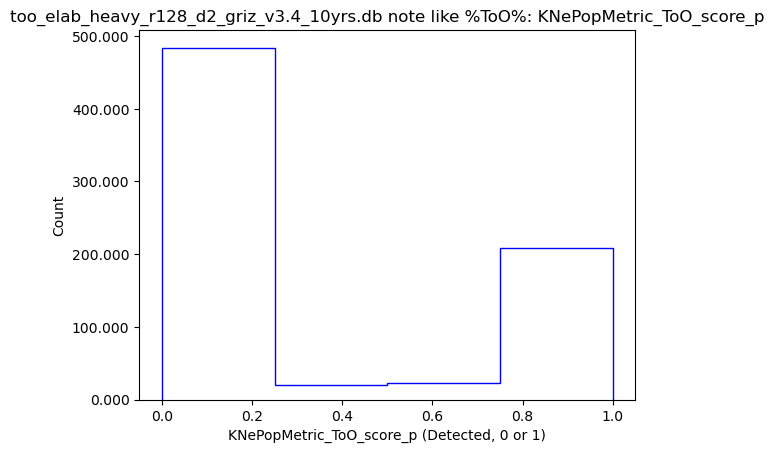

In [21]:
score_p.plot()

In [47]:
df = pd.DataFrame([too_slicer.slice_points['too_trigger'], 
                  too_slicer.slice_points['peak_time'],
                   too_slicer.slice_points['ra'],
                   too_slicer.slice_points['dec'],
                   count_too.metric_values.filled(0),
                   time_too.metric_values.filled(0),
                   map_too.metric_values.filled(0),
                   map_time_too.metric_values.filled(0),
                   map_tmin_too.metric_values.filled(0) - too_slicer.slice_points['peak_time'],
                   nfilters_too.metric_values.filled(0),
                   depth_too['g'].metric_values.filled(100),
                   score_p.metric_values.filled(-999)],
            index=['too_trigger', 'peak_time', 'ra', 'dec', 
                   'nvisits_too', 'time_too', 'nvisits_map', 'time_map',  'time_to_response',
                   'nfilters_map', 'coadd', 'score_p',]).T
df

,too_trigger,peak_time,ra,dec,nvisits_too,time_too,nvisits_map,time_map,time_to_response,nfilters_map,coadd,score_p
0,0.0,60812.918464,3.883987,-0.629859,459.0,0.227037,67.0,3378.117090,0.069669,4.0,26.191516,1.000000
1,1.0,60814.487435,4.413718,-0.427034,96.0,0.049638,32.0,0.046242,0.873251,4.0,25.168629,1.000000
2,2.0,60816.169533,3.516376,1.118734,0.0,0.000000,0.0,0.000000,-60816.169533,0.0,100.000000,-999.000000
3,3.0,60819.324396,0.061392,1.024003,0.0,0.000000,0.0,0.000000,-60819.324396,0.0,100.000000,-999.000000
4,4.0,60821.392657,2.051217,0.195496,0.0,0.000000,0.0,0.000000,-60821.392657,0.0,100.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1275,1275.0,64436.216047,6.001166,0.404358,0.0,0.000000,0.0,0.000000,-64436.216047,0.0,100.000000,-999.000000
1276,1276.0,64437.083205,3.283446,-1.045369,381.0,0.175978,45.0,0.164092,0.085237,4.0,24.665075,0.867521
1277,1277.0,64437.997237,1.882227,0.867497,0.0,0.000000,0.0,0.000000,-64437.997237,0.0,100.000000,-999.000000
1278,1278.0,64440.954339,0.482939,-1.050152,0.0,0.000000,0.0,0.000000,-64440.954339,0.0,100.000000,-999.000000


In [23]:
observed = df.query('nvisits_too > 0')
observed

,too_trigger,peak_time,ra,dec,nvisits_too,time_too,nvisits_map,time_map,nfilters_map,coadd_r,score_p
0,0.0,60812.918464,3.883987,-0.629859,459.0,0.227037,67.0,3378.117090,4.0,25.502375,1.000000
1,1.0,60814.487435,4.413718,-0.427034,96.0,0.049638,32.0,0.046242,4.0,24.983749,1.000000
10,10.0,60840.394219,2.493942,0.190953,178.0,1.013148,36.0,1792.074145,4.0,23.954371,0.663423
13,13.0,60848.572217,4.332036,0.047143,332.0,0.150312,123.0,2491.211071,4.0,25.662134,1.000000
15,15.0,60852.455292,1.257581,-0.284786,23.0,0.010649,4.0,0.001250,1.0,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1270,1270.0,64412.171688,2.191704,0.240324,36.0,1.003220,0.0,0.000000,0.0,100.000000,-999.000000
1271,1271.0,64413.820031,0.697422,-0.664685,109.0,1.012243,113.0,3190.630404,4.0,25.650663,0.000000
1272,1272.0,64416.243407,5.078292,-0.703968,370.0,1.041596,42.0,185.142360,4.0,24.652684,0.000000
1276,1276.0,64437.083205,3.283446,-1.045369,381.0,0.175978,45.0,0.164092,4.0,24.665785,0.867521


In [37]:
classified = observed.query('score_p > 0')
classified.score_p.min()

0.029415107686994513

Text(0, 0.5, 'Score P')

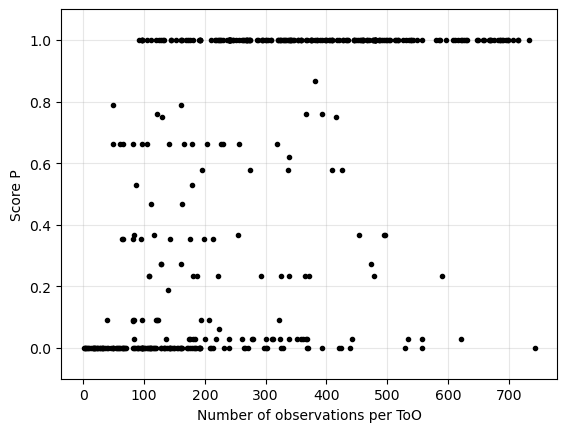

In [38]:
plt.plot(observed.nvisits_too, observed.score_p, 'k.')
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.xlabel("Number of observations per ToO")
plt.ylabel("Score P")

Text(0, 0.5, 'Score P')

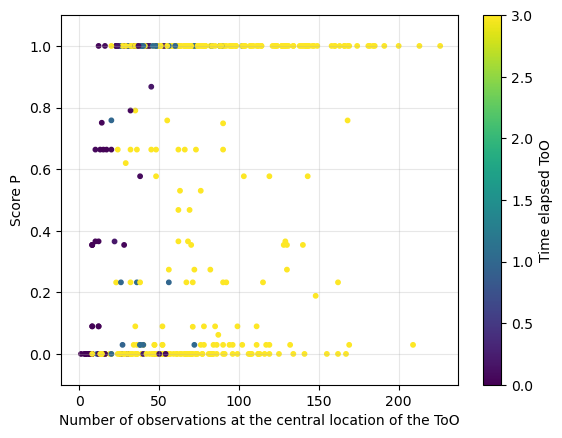

In [39]:
plt.scatter(observed.nvisits_map, observed.score_p, c=observed.time_map, vmin=0, vmax=3, s=10)
plt.colorbar(label='Time elapsed ToO')
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.xlabel("Number of observations at the central location of the ToO")
plt.ylabel("Score P")

In [45]:
pd.DataFrame([len(events), len(observed), observed.nvisits_too.sum(), 
              classified.nvisits_map.mean(), len(classified), classified.score_p.sum(), classified.score_p.mean(),
             len(classified)/len(observed)],
             index=['Total number of events', 'Number of observed events', 'Total number of ToO visits',
                    'Mean number of visits @ToO', 'Total number of classifiable events',  
                    'Total score P (classifiable)', 'Mean score P (classifable)', 'Fraction classified/observed'],
            columns=[run_name])   

,too_elab_heavy_r128_d2_griz_v3.4_10yrs.db
Total number of events,1280.000000
Number of observed events,430.000000
Total number of ToO visits,119071.000000
Mean number of visits @ToO,75.973510
Total number of classifiable events,302.000000
Total score P (classifiable),232.912727
Mean score P (classifable),0.771234
Fraction classified/observed,0.702326
